In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py

In [2]:
datadir = "/Users/yuxi/Library/CloudStorage/GoogleDrive-kyx@stanford.edu/Shared drives/NNN_project/data/Tabular"
arr = pd.read_csv(os.path.join(datadir, 'arr_v0.csv')).set_index('SEQID')
df = pd.read_csv(os.path.join(datadir, 'UVMeltFitResultAggMerged.csv'), index_col=0)

In [3]:
%%time
arr, data_split_dict = fileio.read_ml_data('./data/models/raw', append_2_arr=True)
# arr = pd.read_csv(os.path.join(datadir, 'arr_v0.csv')).set_index('SEQID').dropna(subset=['TargetStruct'])
feats = mf.get_feature_count_matrix(arr, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
print(feats.shape)

(19696, 1331)
CPU times: user 14.2 s, sys: 196 ms, total: 14.4 s
Wall time: 14.3 s


In [4]:
with open('./data/uv_melt/correction.pkl', 'rb') as fh:
    correction_dict = pickle.load(fh)

santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr['dG_37'] = uv.correct_param(arr, correction_dict, 'dG_37')

## Predict array data

CPU times: user 1min 31s, sys: 1min 4s, total: 2min 36s
Wall time: 34.4 s


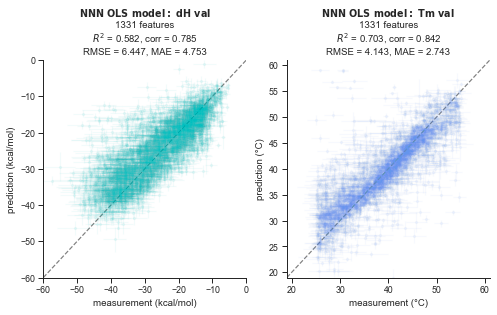

In [13]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
fit_param(arr, data_split_dict, param='dH', feats=feats, ax=ax[0])
fit_param(arr, data_split_dict, param='Tm', feats=feats, ax=ax[1])

#util.save_fig('./fig/models/ols/validation_220824_sep_base_stack_mm_asym.pdf', fig)

CPU times: user 1min 13s, sys: 47.3 s, total: 2min
Wall time: 32.2 s


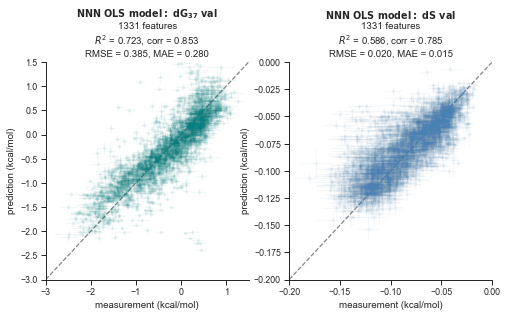

In [23]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(8,4))
mf.fit_param(arr, data_split_dict, param='dG_37', feats=feats, ax=ax[0], mode='val')
mf.fit_param(arr, data_split_dict, param='dS', feats=feats, ax=ax[1], mode='val')

#util.save_fig('./fig/models/ols/validation_220824_sep_base_stack_sym_dG_dS.pdf', fig)

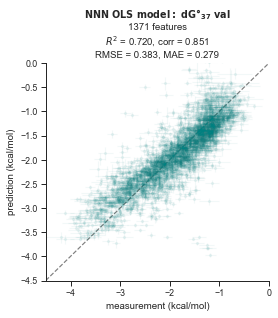

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
lr = mf.fit_param(arr, data_split_dict, param='dG_37', feats=feats, ax=ax, mode='val')
# util.save_fig('./data/models/saved/ols_dG_37_model.pdf', fig)

In [44]:
with open('./data/models/saved/ols_dG_37_model.pkl', 'wb') as fh:
    pickle.dump(lr, fh)

In [58]:
fit_df = pd.DataFrame(data=lr.coef_, index=feats.columns, columns=['dG_37'])

In [92]:
santa_lucia['feats'] = santa_lucia['motif'].apply(lambda x: x.replace('_','+') + '_((+))')
fit_vs_sl = santa_lucia.set_index('feats').join(fit_df, lsuffix='_SantaLucia', rsuffix='_NNN')
fit_vs_sl['nearest neighbors'] = fit_vs_sl['motif'].apply(lambda x: x.replace('_','/'))

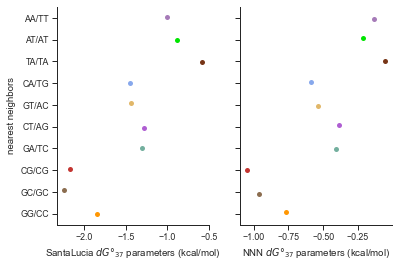

In [163]:
fig, ax = plt.subplots(1, 2, sharey=True)
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_SantaLucia', ax=ax[0], palette='cet_glasbey_dark')
ax[0].set_xlabel(r'SantaLucia $dG°_{37}$ parameters (kcal/mol)')
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_NNN', ax=ax[1], palette='cet_glasbey_dark')
ax[1].set_xlabel(r'NNN $dG°_{37}$ parameters (kcal/mol)')
ax[1].set_ylabel('')
sns.despine()
# util.save_fig('./fig/motif_fit/WC_NNN_vs_SantaLucia_dG_37.pdf')

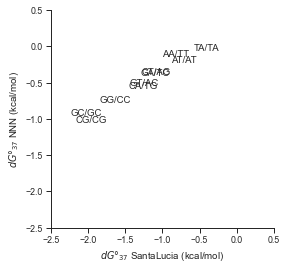

In [206]:
fig, ax = plt.subplots(figsize=(4,4))
for i in range(len(fit_vs_sl)):
    plt.text(fit_vs_sl.dG_37_SantaLucia[i], fit_vs_sl.dG_37_NNN[i], fit_vs_sl.motif[i].replace('_','/'))
    
plt.xlim([-2.5,.5])
plt.ylim([-2.5,.5])

plt.xlabel('$dG°_{37}$ SantaLucia (kcal/mol)')
plt.ylabel('$dG°_{37}$ NNN (kcal/mol)')
sns.despine()

util.save_fig('./fig/motif_fit/WC_NNN_vs_SantaLucia_dG_scatter.pdf')

## Predict the UV melting data

In [116]:
datadir = "/Volumes/GoogleDrive-100816705203527042003/Shared drives/NNN_project/data/Tabular"
df = pd.read_csv(os.path.join(datadir, 'UVMeltFitResultAggMerged.csv'), index_col=0)
df['dG_37'] = uv.correct_param(df, correction_dict, 'dG_37')

In [117]:
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_std < 0.5'
df_q = df.query(plot_query)
df_q['seqidnum'] = df_q['SEQID'].apply(lambda x: int(x[2:]))
df_q = df_q.sort_values(by='seqidnum')

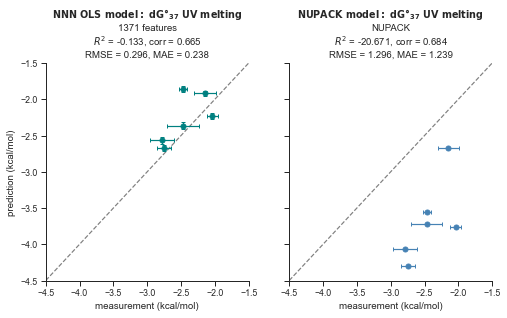

In [203]:
color_dict = dict(dH='c', Tm='cornflowerblue', dG_37='teal', dS='steelblue')
test_data = dict(
    X=feats.loc[df_q.SEQID,:].values,
    y=df_q['dG_37'].values,
    y_err=df_q['dG_37_std'].values,
    param='dG_37',
    split='UV melting'
)
param = 'dG_37'

# y_pred = lr.predict(test_data['X'])
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)
lim = (-4.5,-1.5)
kwargs = dict(alpha=1, lim=lim, marker='o', markersize=5, capsize=2)
plotting.plot_truth_predict(lr, test_data, ax=ax[0], title='NNN OLS model',
                        color=color_dict[param], **kwargs)
plotting.plot_truth_predict(None, test_data, ax=ax[1], title='NUPACK model',
                            nupack_prediction=df_q['dG_37_NUPACK_salt_corrected'],
                        color=color_dict['dS'], **kwargs)
ax[1].set_ylabel('')
util.save_fig('./fig/UV_melt/model_pred_test_NNN_vs_NUPACK.pdf')

<AxesSubplot:title={'center':'$\\bf{NNN\\ OLS\\ model:\\ dG°_{37}\\ test}$\nNUPACK\n$R^2$ = -20.671, corr = 0.684\nRMSE = 1.296, MAE = 1.239'}, xlabel='measurement (kcal/mol)', ylabel='prediction (kcal/mol)'>

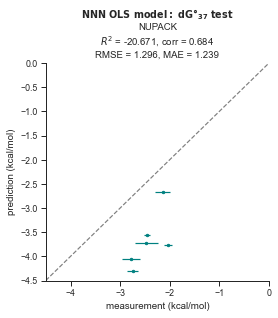

In [181]:
fig, ax = plt.subplots(figsize=(4,4))


## Predict one query variant

In [56]:
from nnn import feature_list
q_row = arr.loc['WC98']
q_feat_list = feature_list.get_feature_list(q_row, fit_intercept=False, symmetry=False, sep_base_stack=True)

pred = lr.coef_df.loc[q_feat_list].sum().values[0]
gt = q_row.dG_37
print("%.4f\t%.4f" % (pred, gt))

-2.2426	-2.3180


In [78]:
mf.pred_variant(arr.loc['WC1025'], lr)

{'pred': -1.853932534542216, 'gt': -2.5186284641443932}

In [73]:
stem_len = int((len(row.RefSeq) - 4.0) / 2.0)
row.TargetStruct = row.TargetStruct.replace('....','+')
row.RefSeq = row.RefSeq[:stem_len] + '+' + row.RefSeq[-stem_len:]

In [76]:
row.RefSeq, row.TargetStruct

('GTTTTTG+CAAAAAC', '(((((((+)))))))')

In [88]:
row = util.get_duplex_row(arr, 'WC1025')

In [116]:
nn_list = feature_list.get_stem_nn_feature_list(arr.loc['WC1025'])


In [119]:
pred = lr.coef_df.loc[nn_list].sum().values[0]

In [212]:
feature_list.get_feature_list(arr.loc['WC1025'], sep_base_stack=True)

['GAAA_....',
 'G+C_(+)',
 'TG+CA_((+))',
 'TT+AA_((+))',
 'TT+AA_((+))',
 'TT+AA_((+))',
 'TT+AA_((+))',
 'GT+AC_((+))',
 'xG+Cy_((+))']

In [122]:
lr.coef_df.loc[nn_list]

,dG_37
xG+Cy_((+)),0.025009
GT+AC_((+)),-0.529731
TT+AA_((+)),-0.109872
TT+AA_((+)),-0.109872
TT+AA_((+)),-0.109872
xA+Ty_((+)),0.676706


In [126]:
result_df = pd.read_csv(os.path.join(datadir, 'UVMeltFitResultAggMerged.csv'), index_col=0)

In [129]:
result_df.query('SEQID == "WC1025" & ~is_hairpin')

,SEQID,conc_uM,Na_mM,dH_uv,dH_std,Tm_uv,Tm_std,dG_37_uv,dG_37_std,dS_uv,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
5,WC1025,72.0,25,-64.679303,5.650261,6.715992,0.219235,6.99645,0.555261,-9.622035,...,-5.548967,(((((((....))))))),-5.49,-4.27945,-3.78258,27.777778,59.035799,-3.555597,-53.6,-0.155118


In [130]:
lr.coef_df.loc['AA+TT_((+))']

dG_37   -0.129711
Name: AA+TT_((+)), dtype: float64

In [150]:
util.get_seq_structure_dG(seq, struct, 37, param_set='dna-nnn')

-5.49

In [148]:
seq

'GTTTTTGGAAACAAAAAC'

## Play with NUPACK assumptions

In [16]:
lr = fileio.read_pickle('./data/models/saved/ols_dG_37_model.pkl')

param_dir = '/Users/yuxi/opt/anaconda3/envs/nnn/lib/python3.8/site-packages/nupack/parameters'

with open(os.path.join(param_dir, 'dna04.json'), 'r') as fh:
    nupack_param = json.load(fh)

In [7]:
nupack_param['dG'].keys()

dict_keys(['bulge_size', 'coaxial_stack', 'dangle_3', 'dangle_5', 'hairpin_size', 'hairpin_mismatch', 'hairpin_tetraloop', 'hairpin_triloop', 'interior_1_1', 'interior_1_2', 'interior_2_2', 'interior_mismatch', 'interior_size', 'join_penalty', 'log_loop_penalty', 'multiloop_base', 'multiloop_init', 'multiloop_pair', 'asymmetry_ninio', 'stack', 'terminal_penalty', 'terminal_mismatch'])

### triloop

In [8]:
nupack_param['dG']['hairpin_triloop']

{'AGAAT': -1.0,
 'AGCAT': -1.0,
 'AGGAT': -1.0,
 'AGTAT': -1.0,
 'CGAAG': -2.0,
 'CGCAG': -2.0,
 'CGGAG': -2.0,
 'CGTAG': -2.0,
 'GGAAC': -2.0,
 'GGCAC': -2.0,
 'GGGAC': -2.0,
 'GGTAC': -2.0,
 'TGAAA': -1.0,
 'TGCAA': -1.0,
 'TGGAA': -1.0,
 'TGTAA': -1.0}

In [18]:
triloop = pd.DataFrame(index=['dG_37'], data=nupack_param['dG']['hairpin_triloop']).T.reset_index()
triloop.columns = ['feat', 'dG_37']
triloop['base_stack'] = triloop['feat'].apply(lambda x: x[0]+x[-1])
triloop['loop'] = triloop['feat'].apply(lambda x: x[1:4])

Text(0.5, 1.0, 'NUPACK triloop parameters')

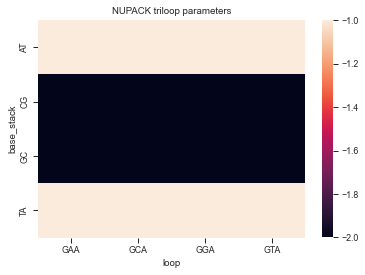

In [20]:
triloop_pivot = triloop.pivot(columns='loop', index='base_stack', values='dG_37')
sns.heatmap(triloop_pivot)
plt.title('NUPACK triloop parameters')

In [21]:
lr.coef_df[lr.coef_df.reset_index()['index'].apply(lambda x: x.split('_')[1] == '...').tolist()]

,dG_37
AAA_...,0.402584
AAC_...,0.270816
AAG_...,0.340999
AAT_...,0.546963
ACA_...,0.057857
...,...
TGT_...,0.042353
TTA_...,0.009031
TTC_...,-0.092487
TTG_...,0.263359


In [22]:
loop_nnn = lr.coef_df.loc[[loop+'_...' for loop in triloop_pivot.columns]]
base_stack_nnn = lr.coef_df.loc[[stack[0]+'+'+stack[1]+'_(+)' for stack in triloop_pivot.index]]

In [24]:
base_stack_nnn

,dG_37
A+T_(+),0.300243
C+G_(+),-0.680556
G+C_(+),-0.002094
T+A_(+),-0.028056


In [234]:
triloop_pivot_nnn.loc['AT','GAA']

-1.0

In [249]:
triloop_pivot_nnn = triloop_pivot.copy()
for loop in loop_nnn.index:
    for base_stack in base_stack_nnn.index:
        triloop_pivot_nnn.loc[base_stack.split('_')[0].replace('+', ''), loop.split('_')[0]] = loop_nnn.loc[loop].values[0] + base_stack_nnn.loc[base_stack].values[0]
        

<AxesSubplot:title={'center':'NUPACK triloop parameters'}, xlabel='loop', ylabel='base_stack'>

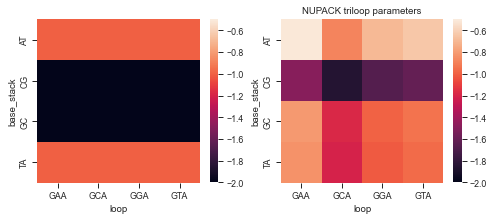

In [251]:
#triloop_pivot = triloop.pivot(columns='loop', index='base_stack', values='dG_37')
kwargs = dict(vmin=-2, vmax=-0.5)

fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.heatmap(triloop_pivot, ax=ax[0], **kwargs)
plt.title('NUPACK triloop parameters')

sns.heatmap(triloop_pivot_nnn, ax=ax[1], **kwargs)

In [ ]:
from scipy.spatial.distance import pdist
dist = pdist(feats)

### longer loops

In [88]:
def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]

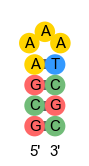

AAA AT


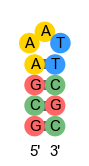

AAT AT


In [52]:
tmpdf = arr.query('Series == "TRIloop" & ConstructType == "NN" & scaffold == "GCGC_nan"')
for i in range(2):
    draw_struct(tmpdf.iloc[i].RefSeq, tmpdf.iloc[i].TargetStruct)
    print(tmpdf.iloc[i].RefSeq[4:7], tmpdf.iloc[i].RefSeq[3]+tmpdf.iloc[i].RefSeq[7])

In [11]:
np.unique(arr.Series)

array(['Bulges', 'External', 'MisMatches', 'TETRAloop', 'TRIloop',
       'VARloop', 'WatsonCrick'], dtype=object)

In [199]:
tmpdf = arr.query('Series == "TRIloop"')

tmpdf['loop'] = tmpdf.RefSeq.apply(lambda x: get_loop(x, loop_size=3))
tmpdf['base_stack'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 3, 2))
tmpdf['loopmid'] = tmpdf.loop.apply(lambda x: x[1])
tmpdf['loopmm'] = tmpdf.loop.apply(lambda x: x[0] + x[2])

dG_median = tmpdf.groupby(['ConstructType', 'scaffold']).dG_37.apply(np.nanmedian)
tmpdf['ddG_37'] = tmpdf.apply(lambda row: row.dG_37 - dG_median[row.ConstructType][row.scaffold], axis=1)
dH_median = tmpdf.groupby(['ConstructType', 'scaffold']).dH.apply(np.nanmedian)
tmpdf['ddH'] = tmpdf.apply(lambda row: row.dH - dG_median[row.ConstructType][row.scaffold], axis=1)

In [106]:
triloop_mat = tmpdf.pivot_table(values='dG_37', columns='loop', index='base_stack', fill_value=np.median(0))
triloop_mat

loop,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
base_stack,,,,,,,,,,,,,,,,,,,,,
AT,-1.826094,-1.592885,-1.477660,-1.480227,-1.549643,-1.571484,-1.856292,-1.577932,-1.407147,-1.646828,...,-1.684475,-1.951704,-1.540067,-1.839015,-1.561322,-1.849971,-1.905285,-2.009196,-1.734160,-2.027034
CG,-3.155020,-3.252230,-3.526913,-3.169129,-3.274962,-2.919913,-2.972337,-3.031662,-3.115218,-3.390217,...,-3.043120,-3.222467,-2.899633,-3.256208,-3.085696,-3.038341,-3.221119,-2.988750,-3.116470,-3.074238
GC,-2.335544,-2.236018,-2.225911,-2.127941,-2.616192,-2.392926,-2.349568,-2.139360,-2.316404,-2.263560,...,-2.013959,-2.439321,-2.379565,-2.643177,-2.008308,-2.684954,-2.840396,-2.797289,-2.285275,-2.655646
TA,-2.185156,-2.498343,-2.052068,-1.957679,-2.360044,-2.530073,-2.136795,-2.502126,-2.195830,-2.266084,...,-2.191986,-2.550474,-2.012090,-2.624683,-1.872759,-2.441237,-2.292829,-2.603410,-1.776629,-2.775467


In [107]:
Q, R = np.linalg.qr(triloop_mat)

sns.heatmap(Q)

sns.heatmap(R)

np.max(np.abs(Q@R - triloop_mat))

In [217]:
from statsmodels.multivariate.manova import MANOVA

# add the intercept
#tmpdf['Treatment'] = ['trt ' + str(x) for x in data['Treatment']]

# fit manova
manova_result = MANOVA.from_formula('ddG_37 + ddH ~ loop', tmpdf)
#print(manova_result.mv_test())

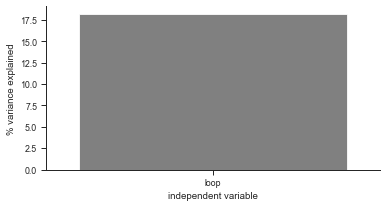

In [218]:
fig, ax = plt.subplots(figsize=(6,3))
manova_stat = manova_result.mv_test().summary_frame.reset_index().query('''Statistic == "Wilks' lambda"''').drop(index=0)
manova_stat['% variance explained'] = (1 - manova_stat['Value']) * 100
sns.barplot(data=manova_stat, x='Effect', y='% variance explained', color='gray')
ax.set_xlabel("independent variable")
# ax.set_xticklabels(['middle of loop', '1st mismatch in loop', 'closing pair'])
sns.despine()

util.save_fig('./fig/stat_test/MANOVA_triloop.pdf')

Seems that base stack has the biggest contribution to dG_37 and dH

Now let's try tetraloops

In [187]:
tmpdf = arr.query('Series == "TETRAloop"')

tmpdf['loop'] = tmpdf.RefSeq.apply(lambda x: get_loop(x, loop_size=4))
tmpdf['base_stack1'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 4, 1))
tmpdf['base_stack2'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 4, 2)[0] + get_closing_stack(x, 4, 2)[-1])
tmpdf['loopmid'] = tmpdf.loop.apply(lambda x: x[1:3])
tmpdf['loopmm'] = tmpdf.loop.apply(lambda x: x[0] + x[-1])

dG_median = tmpdf.groupby(['ConstructType', 'scaffold']).dG_37.apply(np.nanmedian)
tmpdf['ddG_37'] = tmpdf.apply(lambda row: row.dG_37 - dG_median[row.ConstructType][row.scaffold], axis=1)
dH_median = tmpdf.groupby(['ConstructType', 'scaffold']).dH.apply(np.nanmedian)
tmpdf['ddH'] = tmpdf.apply(lambda row: row.dH - dG_median[row.ConstructType][row.scaffold], axis=1)

In [188]:
manova_result = MANOVA.from_formula('ddG_37 + ddH ~ loopmid + loopmm + base_stack1 + base_stack2', tmpdf)
print(manova_result.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.2522 2.0000 3519.0000 5216.8479 0.0000
         Pillai's trace 0.7478 2.0000 3519.0000 5216.8479 0.0000
 Hotelling-Lawley trace 2.9650 2.0000 3519.0000 5216.8479 0.0000
    Roy's greatest root 2.9650 2.0000 3519.0000 5216.8479 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
         loopmid         Value   Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.7965 30.0000 7038.0000 28.2593 0.0000
          Pillai's trace 0.2075 30.0000 7040.

In [192]:
manova_result.mv_test().summary_frame.reset_index().query('''Statistic == "Wilks' lambda"''')

,Effect,Statistic,Value,Num DF,Den DF,F Value,Pr > F
0,Intercept,Wilks' lambda,0.252209,2,3519.0,5216.847916,0.0
4,loopmid,Wilks' lambda,0.796543,30,7038.0,28.259275,0.0
8,loopmm,Wilks' lambda,0.387551,30,7038.0,142.245731,0.0
12,base_stack1,Wilks' lambda,0.231804,6,7038.0,1263.335512,0.0
16,base_stack2,Wilks' lambda,0.175429,6,7038.0,1627.572168,0.0


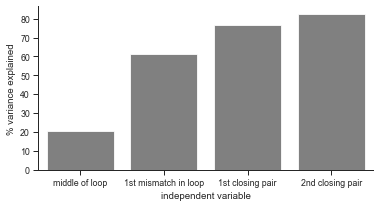

In [198]:
manova_stat = manova_result.mv_test().summary_frame.reset_index().query('''Statistic == "Wilks' lambda"''').drop(index=0)
manova_stat['% variance explained'] = (1 - manova_stat['Value']) * 100
fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(data=manova_stat, x='Effect', y='% variance explained', color='gray')
# ax.set_ylabel("Pillai's trace")
ax.set_xlabel("independent variable")
ax.set_xticklabels(['middle of loop', '1st mismatch in loop', '1st closing pair', '2nd closing pair'])
sns.despine()
util.save_fig('./fig/stat_test/MANOVA_tetraloop.pdf')

In [222]:
def calc_zscore(df, param):
    p_mean = df.groupby(['ConstructType', 'scaffold'])[param].apply(np.nanmean)
    p_std = df.groupby(['ConstructType', 'scaffold'])[param].apply(np.nanstd)
    df[param+'_zscore'] = df.apply(lambda row: (row[param] - p_mean[row.ConstructType][row.scaffold]) / p_std[row.ConstructType][row.scaffold] , axis=1)

calc_zscore(tmpdf, 'dG_37')
calc_zscore(tmpdf, 'dH')

In [254]:
def get_perc_var_df(tmpdf, indep_var, indep_var_name):
    calc_zscore(tmpdf, 'dG_37')
    calc_zscore(tmpdf, 'dH')
    
    result_df = pd.DataFrame(index=indep_var, columns=['lambda','%variance explained'])
    for v in indep_var:
        manova_result = MANOVA.from_formula('dG_37_zscore + dH_zscore ~ %s'% v, tmpdf)
        result_df.loc[v, 'lambda'] = manova_result.mv_test().summary_frame.loc[v].loc["Wilks' lambda"]['Value']


    result_df['%variance explained'] = (1 - result_df['lambda']) * 100
    result_df['independent variable'] = indep_var_name
    # result_df.loc['unexplained', '%variance explained'] = 1 - n
    
    return result_df

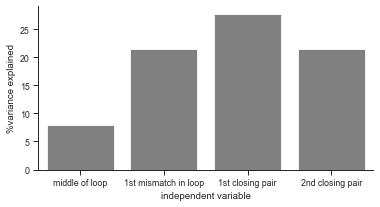

In [263]:
tmpdf = arr.query('Series == "TETRAloop"')

tmpdf['loop'] = tmpdf.RefSeq.apply(lambda x: get_loop(x, loop_size=4))
tmpdf[ 'closing_stack1'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 4, 1))
tmpdf['closing_stack2'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 4, 2)[0] + get_closing_stack(x, 4, 2)[-1])
tmpdf['loopmid'] = tmpdf.loop.apply(lambda x: x[1:3])
tmpdf['loopmid1'] = tmpdf.loop.apply(lambda x: x[1])
tmpdf['loopmm'] = tmpdf.loop.apply(lambda x: x[0] + x[-1])
indep_var = ['loopmid', 'loopmm', 'closing_stack1', 'closing_stack2']
indep_var_name = ['middle of loop', '1st mismatch in loop', '1st closing pair', '2nd closing pair']

result_df = get_perc_var_df(tmpdf, indep_var, indep_var_name)

fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(data=result_df, x='independent variable', y='%variance explained', color='gray')
sns.despine()
util.save_fig('./fig/stat_test/MANOVA_tetraloop.pdf')

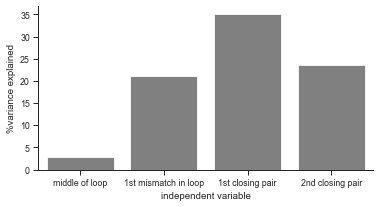

In [264]:
tmpdf = arr.query('Series == "TRIloop"')

tmpdf['loop'] = tmpdf.RefSeq.apply(lambda x: get_loop(x, loop_size=3))
tmpdf[ 'closing_stack1'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 3, 1))
tmpdf['closing_stack2'] = tmpdf.RefSeq.apply(lambda x: get_closing_stack(x, 3, 2)[0] + get_closing_stack(x, 4, 2)[-1])
tmpdf['loopmid'] = tmpdf.loop.apply(lambda x: x[1])
tmpdf['loopmm'] = tmpdf.loop.apply(lambda x: x[0] + x[2])
indep_var = ['loopmid', 'loopmm', 'closing_stack1', 'closing_stack2']
indep_var_name = ['middle of loop', '1st mismatch in loop', '1st closing pair', '2nd closing pair']

result_df = get_perc_var_df(tmpdf, indep_var, indep_var_name)

fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(data=result_df, x='independent variable', y='%variance explained', color='gray')
sns.despine()
util.save_fig('./fig/stat_test/MANOVA_triloop.pdf')